# Ejemplo completo para un problema de regresión usando sci-kitlearn

El siguiente ejemplo presenta las etapas básicas de un proyecto de analítica de datos en una tarea de regresión, orientadas a:

- Preproceso de atributos con campos vacios y tipo texto.
- Entrenamiento y selección de un modelo de regresión bajo una estrategia de validación cruzada.
- La utilización de diccionarios para la sintonización de hiperparámetros.
-Se ilustra también la creación de clases (objetos) propios compatibles con la clase pipeline de sci-kitlearn.

**Base de datos utilizada**: [FIFA 2019 - Kaggle](https://www.kaggle.com/datasets/devansodariya/football-fifa-2019-dataset).

In [36]:
#cargar datos desde drive acceso libre
FILEID = "15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

--2024-09-29 20:35:35--  https://docs.google.com/uc?export=download&confirm=&id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe
Resolving docs.google.com (docs.google.com)... 142.251.2.102, 142.251.2.101, 142.251.2.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe&export=download [following]
--2024-09-29 20:35:35--  https://drive.usercontent.google.com/download?id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2424 (2.4K) [text/html]
Saving to: ‘codigos.zip’

codigos.zip         100%[===================>]   2.37K  --.-KB/s    in 0s      

2024-0

# Lectura de la base de datos con Pandas

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#librerias para proceso
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline
csv_path = 'Main_Fifa/datos/data.csv' #directorio de la base de datos en disco de colaboratory según archivo cargado

Xdata = pd.read_csv(csv_path)#leer archivo csv

col_drop = ['Unnamed: 0', 'Name','ID','Photo','Flag',
           'Club Logo','Loaned From'] #variables a descartar - no contienen información relevante
Xdata.drop(columns = col_drop, inplace = True)
Xdata.head()

Age Nationality  Overall  Potential                 Club    Value   Wage  \
0   31   Argentina       94         94         FC Barcelona  €110.5M  €565K   
1   33    Portugal       94         94             Juventus     €77M  €405K   
2   26      Brazil       92         93  Paris Saint-Germain  €118.5M  €290K   
3   27       Spain       91         93    Manchester United     €72M  €260K   
4   27     Belgium       91         92      Manchester City    €102M  €355K   

   Special Preferred Foot  International Reputation  ...  Composure  Marking  \
0     2202           Left                       5.0  ...       96.0     33.0   
1     2228          Right                       5.0  ...       95.0     28.0   
2     2143          Right                       5.0  ...       94.0     27.0   
3     1471          Right                       4.0  ...       68.0     15.0   
4     2281          Right                       4.0  ...       88.0     68.0   

  StandingTackle SlidingTackle GKDiving GKHandling  GKKicking GKPositioning  \
0           28.0          26.0      6.0       11.0       15.0          14.0   
1           31.0          23.0      7.0       11.0       15.0          14.0   
2           24.0          33.0      9.0        9.0       15.0          15.0   
3           21.0          13.0     90.0       85.0       87.0          88.0   
4           58.0          51.0     15.0       13.0        5.0          10.0   

  GKReflexes Release Clause  
0        8.0        €226.5M  
1       11.0        €127.1M  
2       11.0        €228.1M  
3       94.0        €138.6M  
4       13.0        €196.4M  

[5 rows x 82 columns]

# Identificar tipos de variables, campos perdidos y preproceso básico a realizar

In [38]:
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       18207 non-null  int64  
 1   Nationality               18207 non-null  object 
 2   Overall                   18207 non-null  int64  
 3   Potential                 18207 non-null  int64  
 4   Club                      17966 non-null  object 
 5   Value                     18207 non-null  object 
 6   Wage                      18207 non-null  object 
 7   Special                   18207 non-null  int64  
 8   Preferred Foot            18159 non-null  object 
 9   International Reputation  18159 non-null  float64
 10  Weak Foot                 18159 non-null  float64
 11  Skill Moves               18159 non-null  float64
 12  Work Rate                 18159 non-null  object 
 13  Body Type                 18159 non-null  object 
 14  Real F

## Se presentan atributos tipo int, float y texto, algunos de ellos con datos perdidos.

# Partición en conjunto de training y testing.

## Tips básicos para escoger la estrategia de validación:

- Para $N\geq 5000$ se sugiere realizar entrenamiento hold-out, generando grupos de entrenamiento, validación y evaluación. Los conjuntos de entrenamiento y validación se pueden utilizar para realizar validación cruzada de 10 o 5 folds para determinar el mejor modelo y sus hiperparámetros.

- No obstante, si la cantidad de datos es muy grande, generalmente se utiliza un único conjunto de entrenamiento y un único conjunto de validación, e.g., modelos de deep learning generalmente utilizan esta estrategia por la gran cantidad de datos disponible.

**HoldOut con única partición de entrenamiento, validación y evaluación (training, validation, testing)**

![HoldOut](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/3_Intro_Sklearn_Regresion/HoldOut.png?raw=1)


**HoldOut utilizando validación cruzada para definir varios conjuntos de entrenamiento y validación en la búsqueda del mejor modelo con evaluación final en un único conjunto de testing**

![grid_search_cross_validation](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/3_Intro_Sklearn_Regresion/crossvalidation.png?raw=1)

- Se sugiere para $ 30 <N <5000$ realizar validación cruzada o validación cruzada anidad k folds (generalmente se trabaja con k=10 o k = 5), y reportar el desempeño promedio en el conjunto de test a lo largo de las rotaciones.

- En algunos textos, dado que los datos se rotan y aparecen al menos una vez en el conjunto de training y una vez en el de testing, se habla solamente de conjuntos de entrenamiento y validación, porque el concepto de datos afuera (testing) se pierde.

![kfolds](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/3_Intro_Sklearn_Regresion/kfolds.png?raw=1)

- La validación cruzada anidad es mucho más estricta a la hora de dejar un conjunto de test que no se utiliza para sintonizar los hiperparámetros (a diferencia del kfolds convencional que determina los mejores valores de hiperparámetros respecto al conjunto de validación=evaluación). Sin embargo, la validación anidad es más costosa computacionalmente.


![nestedcv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/3_Intro_Sklearn_Regresion/nestedcv.png?raw=1)

- Para $N \leq 30$ se sugiere trabajar con validación cruzada fijando el número de particiones igual al número de datos ($k=N$). En este caso, se tiene un conjunto de entrenamiento de $N-1$ y una única muestra de test que se rota $N$ veces (leave-one-out).



**Nota**: Para el ejemplo ilustrado se cuenta con una buena cantidad de datos 18.000 aprox., por lo que se realizará una validación hold-out, con 70% de datos para entrenamiento y 30% para evaluación. Sobre el conjunto de entrenamiento se realizará una validación cruzada de 5 folds (k=5) para determinar el mejor modelo e hiperparámetros.

Se define el atributo Release Clause como salida.

In [39]:
# Partición entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%

Xtrain, Xtest = train_test_split(Xdata,test_size=0.3)
col_sal = "Release Clause"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)


**Nota**: Recuerde que puede usar la partición estratificada para preservar la distribución de la salida de interés en los folds

# Preproceso: completar datos y codificar datos tipo texto


In [40]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")#se utiliza estimador de moda
ytrain = imputer.fit_transform(pd.DataFrame(ytrain)).reshape(-1)#ajuste sobre la salida
ytest = imputer.transform(pd.DataFrame(ytest)).reshape(-1)#evaluar sobre datos de test

print(ytrain.shape, ytest.shape)

(12744,) (5463,)


**Nota**: Dado que la variable de salida esta en formato moneda se debe codificar meidante función particular (custom). También, se creará una función para codificar las variables tipo evolución características del jugador.

---



In [41]:
ytrain[0]

'€5.5M'

In [42]:
 #codificar variables moneda
def code_euro(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y[i][-1]=='M': yc[i] = float(y[i][1:-1])*10**6 #buscar M y reemplazar 10^6
        elif y[i][-1]=='K': yc[i] = float(y[i][1:-1])*10**3 # buscar K y reemplazar por 10^3
        else: yc[i] = float(y[i][1:])
    return yc

#codificar estadísticas
def code_stats(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y.iloc[i].find("+") > -1: # encontrar signo + en str y casteo a flotante
            yc[i] = float(y.iloc[i][:y.iloc[i].find("+")])+float(y.iloc[i][y.iloc[i].find("+")+1:])
        else: yc[i] = float(y.iloc[i])
    return yc

In [43]:
#codificar salida
ytrain_num = code_euro(ytrain)
ytest_num = code_euro(ytest)

In [44]:
ytrain_num[:5]

array([5500000.,   15000.,  680000.,  297000., 1100000.])

## Se definen las variables para codificar utilizando las funciones establecidas de moneda, estadísticas y las tipo texto con OrdinalEncoder y OneHotEncoder.

In [45]:
#definir columnas tipo string  para codificar moneda, estadistica fifa y categoricas
col_euro = ['Value','Wage'] #variables tipo moneda
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB']#variables tipo mejora jugadores

cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
        'Work Rate','Real Face','Contract Valid Until']#variables a codificar OrdinalEncoder y OneHotEncoder
items = []
for i in cat:
    items += [list(Xdata[i].value_counts().index)]
cat_usr = dict(zip(cat, items))#se crean diccionarios con las variables y sus posibles valores

In [46]:
Xdata['Nationality'].value_counts()

Nationality
England      1662
Germany      1198
Spain        1072
Argentina     937
France        914
             ... 
Belize          1
Liberia         1
Lebanon         1
Palestine       1
Botswana        1
Name: count, Length: 164, dtype: int64

In [47]:
cat_usr.keys()

dict_keys(['Nationality', 'Club', 'Body Type', 'Position', 'Preferred Foot', 'Work Rate', 'Real Face', 'Contract Valid Until'])

In [48]:
cat_usr['Body Type']

['Normal',
 'Lean',
 'Stocky',
 'Messi',
 'C. Ronaldo',
 'Neymar',
 'Courtois',
 'PLAYER_BODY_TYPE_25',
 'Shaqiri',
 'Akinfenwa']

# Se crea clase propia (custom) para ejecutar el preproceso que sea compatible con scikitlearn

In [49]:
#%% transformer custom
from sklearn.base import BaseEstimator, TransformerMixin #objetos básicos para herencia de clase

class mypre_fifa(BaseEstimator,TransformerMixin):
    #inicializacion de clase y varaibles
    def __init__(self, col_euro,col_stats, cat_usr): #constructor clase
        self.col_euro = col_euro #lista atributos tipo moneda
        self.col_stats = col_stats #lista atributos tipo estadistica
        self.cat_usr = cat_usr #lista de atributos categoricos

    def fit(self,X, *_):#función de ajuste -> *_ para indicar que puede recibir más entradas en el pipeline
        Xi = X.copy() #copiar dataset para no reemplazar original
        self.imputer_num = SimpleImputer(strategy="most_frequent") #crear imputador tipo moda
        self.a = Xi.columns[np.sum(Xi.isna())> 0] #encontrar columnas con datos faltantes
        self.imputer_num.fit(Xi[self.a]) # ajustar imputador
        Xi[self.a] = self.imputer_num.transform(Xi[self.a]) #evaluar datos con el imputador

        for i in self.col_euro: #codificar tipo moneda
            Xi[i] = code_euro(np.array(Xi[i]))

        for i in self.col_stats: #codificar datos estadisticos
            Xi[i] = code_stats(Xi[i])

        #height, wieght corregir formato
        Xi['Height'].replace(regex=["'"], value='.',inplace=True) #reemplaza unidad ' con .
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])#elimnar unidades
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])#eliminar unidades

        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')#asegurar formato flotante

        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")#codificar fecha
        Xi['Joined'] = Xi['Joined'].astype('float64')

        cat = [] #codificar variables categoricas con ordinal encoder
        for i in self.cat_usr.keys():
            cat = cat + [[*self.cat_usr.get(i)]]
        self.col_cat_usr = OrdinalEncoder(categories=cat) # OneHotEncoder(categories=cat,sparse=False)
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.fit_transform(Xi[[*self.cat_usr.keys()]])
        #si utilizar OneHotEncoder debe concatenar las columnas resultantes -> ver cuaderno guia lado a lado

        return self

    def transform(self, X, *_):#funcion transformador-> pensando en datos nuevos
        Xi = X.copy()
        Xi[self.a] = self.imputer_num.transform(Xi[self.a])

        for i in self.col_euro:
            Xi[i] = code_euro(np.array(Xi[i]))
        for i in self.col_stats:
            Xi[i] = code_stats(Xi[i])

                #height, wieght
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])

        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')

        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")
        Xi['Joined'] = Xi['Joined'].astype('float64')

        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.transform(Xi[[*self.cat_usr.keys()]])
        return Xi

    def fit_transform(self,X,*_):#ajustar y transformar en cascada
        self.fit(X)
        return self.transform(X)

In [50]:
mypre = mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)
Xtrain_pre = mypre.fit_transform(Xtrain)

**Nota**: Recuerde que ninguna etapa del proceso puede utilizar los datos de test para sintonizar parámetros.

In [51]:
Xtest_pre = mypre.transform(Xtest) #no se puede fit solo transform-> parámetros ajustados sobre Xtrain

In [52]:
Xtrain_pre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12744 entries, 2186 to 8256
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       12744 non-null  int64  
 1   Nationality               12744 non-null  float64
 2   Overall                   12744 non-null  int64  
 3   Potential                 12744 non-null  int64  
 4   Club                      12744 non-null  float64
 5   Value                     12744 non-null  float64
 6   Wage                      12744 non-null  float64
 7   Special                   12744 non-null  int64  
 8   Preferred Foot            12744 non-null  float64
 9   International Reputation  12744 non-null  object 
 10  Weak Foot                 12744 non-null  object 
 11  Skill Moves               12744 non-null  object 
 12  Work Rate                 12744 non-null  float64
 13  Body Type                 12744 non-null  float64
 14  Real Face

Las variables fueron codificadas $X_{train}\in\mathbb{R}^{N \times P}$

# Se realiza análisis exploratorio básico

In [53]:
corr_matrix = Xtrain_pre.corr()#matriz de correlación
corr_matrix.style.background_gradient(cmap='coolwarm')

# Ejercicio 1:

1. Qué puede discutir sobre las correlaciones cálculadas?

2. Cuáles son los atributos que presentan una relación lineal más fuerte con la variable de salida?




Ejercicio 1: Discusión sobre las correlaciones calculadas

Al observar las correlaciones calculadas, se puede identificar que ciertos atributos del conjunto de datos muestran relaciones lineales fuertes entre sí. Específicamente, las variables que representan habilidades de los arqueros (como GKDiving, GKHandling, GKKicking,GKPositioning, y GKReflexes) presentan correlaciones extremadamente altas, cercanas a 1.0. Esto sugiere que estas variables están midiendo aspectos muy similares del rendimiento del arquero, lo que podría generar redundancia en el modelo si no se trata adecuadamente.

Del mismo modo, las posiciones defensivas (como LWB, LDM, CDM, RDM, RWB, LB,LCB, CB, y RCB) también presentan altas correlaciones entre sí. Esto refleja que los jugadores en posiciones defensivas tienden a compartir habilidades comunes, lo que se traduce en una fuerte relación lineal entre estos atributos.

Atributos con la relación lineal más fuerte con la variable de salida

En términos de la variable de salida, si consideramos que esta es una métrica de rendimiento general o similar (aunque no se especifica cuál es la variable de salida en el ejercicio), los atributos con la relación lineal más fuerte probablemente estarían entre los que presentan mayor correlación entre ellos. En este caso, los atributos relacionados con las habilidades de los arqueros (como GKDiving, GKHandling, GKKicking, GKPositioning, y GKReflexes) podrían ser los más relevantes si el jugador es un arquero. Para jugadores de campo, los atributos relacionados con posiciones defensivas (como LWB, LDM, CDM, etc.) serían los más indicados.


Los atributos que presentan una relación lineal más fuerte con la variable de salida dependerán del tipo de jugador (arquero o jugador de campo). Las habilidades de arquero muestran las correlaciones más fuertes entre sí, mientras que las posiciones defensivas también están altamente correlacionadas. Estas correlaciones deben ser consideradas para evitar multicolinealidad en un modelo predictivo y optimizar la selección de variables.



In [55]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

# Continuar después de la clase mypre_fifa
mypre = mypre_fifa(col_euro=col_euro, col_stats=col_stats, cat_usr=cat_usr)

# Preprocesar los datos de entrenamiento y prueba
Xtrain_pre = mypre.fit_transform(Xtrain)
Xtest_pre = mypre.transform(Xtest)

# Convertir 'Release Clause' a valores numéricos
ytrain_num = code_euro(ytrain)
ytest_num = code_euro(ytest)

# Añadir 'Release Clause' de nuevo al dataframe preprocesado
Xtrain_pre['Release Clause'] = ytrain_num

# Verificar que todos los datos son numéricos para calcular la matriz de correlación
print(Xtrain_pre.info())

# Calcular la matriz de correlación
corr_matrix = Xtrain_pre.corr()

# Filtrar la correlación de 'Release Clause'
release_clause_corr = corr_matrix['Release Clause']

# Ordenar las correlaciones por valor absoluto de mayor a menor
release_clause_corr_sorted = release_clause_corr.abs().sort_values(ascending=False)

# Mostrar las 10 variables con mayor correlación con 'Release Clause'
print("Las 10 variables con mayor correlación con 'Release Clause' son:")
print(release_clause_corr_sorted.head(10))

# Visualización opcional de la matriz de correlación
corr_matrix.style.background_gradient(cmap='coolwarm')


<class 'pandas.core.frame.DataFrame'>
Index: 12744 entries, 2186 to 8256
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       12744 non-null  int64  
 1   Nationality               12744 non-null  float64
 2   Overall                   12744 non-null  int64  
 3   Potential                 12744 non-null  int64  
 4   Club                      12744 non-null  float64
 5   Value                     12744 non-null  float64
 6   Wage                      12744 non-null  float64
 7   Special                   12744 non-null  int64  
 8   Preferred Foot            12744 non-null  float64
 9   International Reputation  12744 non-null  object 
 10  Weak Foot                 12744 non-null  object 
 11  Skill Moves               12744 non-null  object 
 12  Work Rate                 12744 non-null  float64
 13  Body Type                 12744 non-null  float64
 14  Real Face

# Ejercicio 2:

Sobre los datos preprocesados de entrenamiento presente las gráficas de histograma, dispersión (scatter matrix) y diagramas de caja para la salida y al menos tres atirbutos de entrada, teniendo en cuenta: i) datos preprocesados, ii) datos preprocesados más StandardScaler, iii) datos preprocesados más MinMaxScaler.

**Nota**: se presentan algunas líneas de código de ayuda.

**SOLUCION EJERCICIO 2**

<Figure size 1200x600 with 0 Axes>

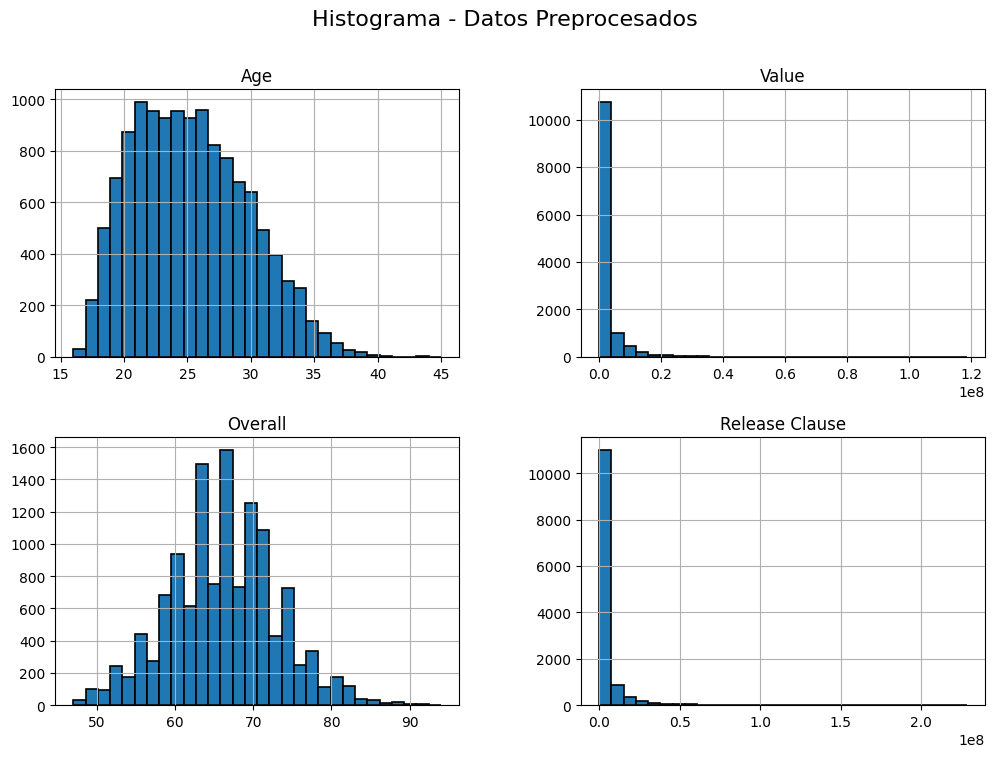

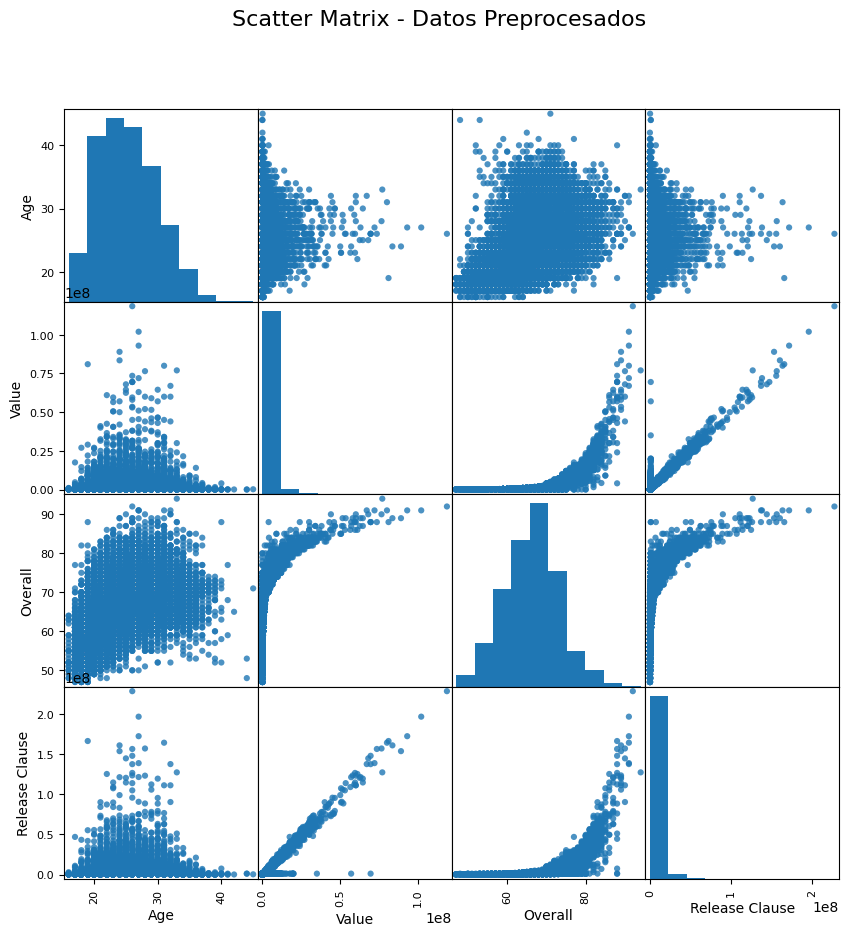

<Figure size 1200x600 with 0 Axes>

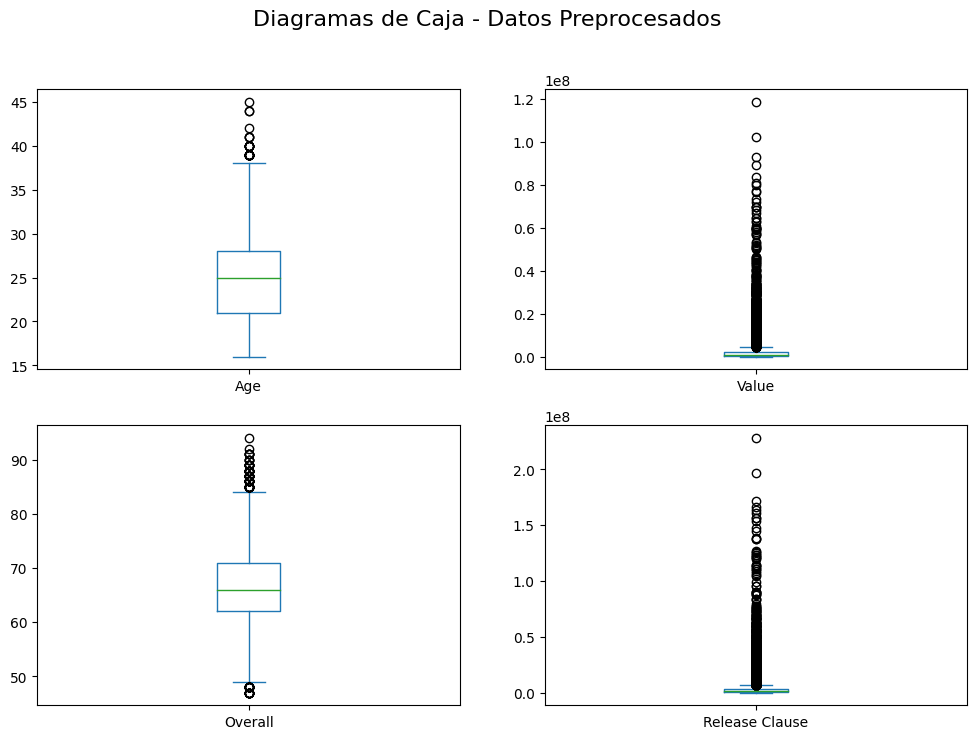

<Figure size 1200x600 with 0 Axes>

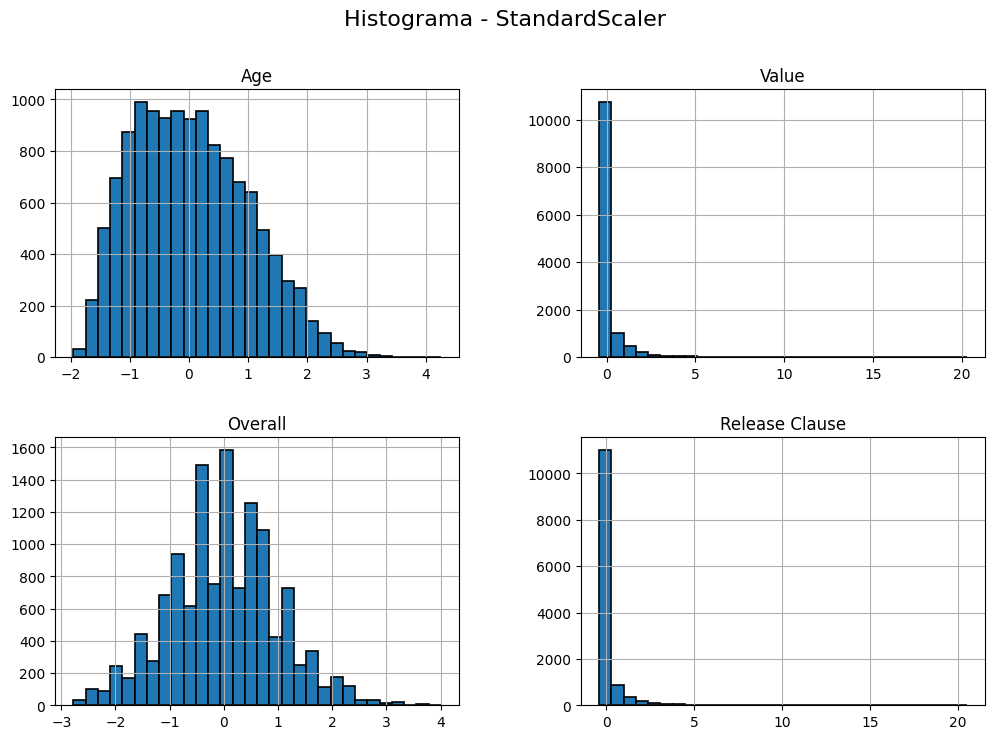

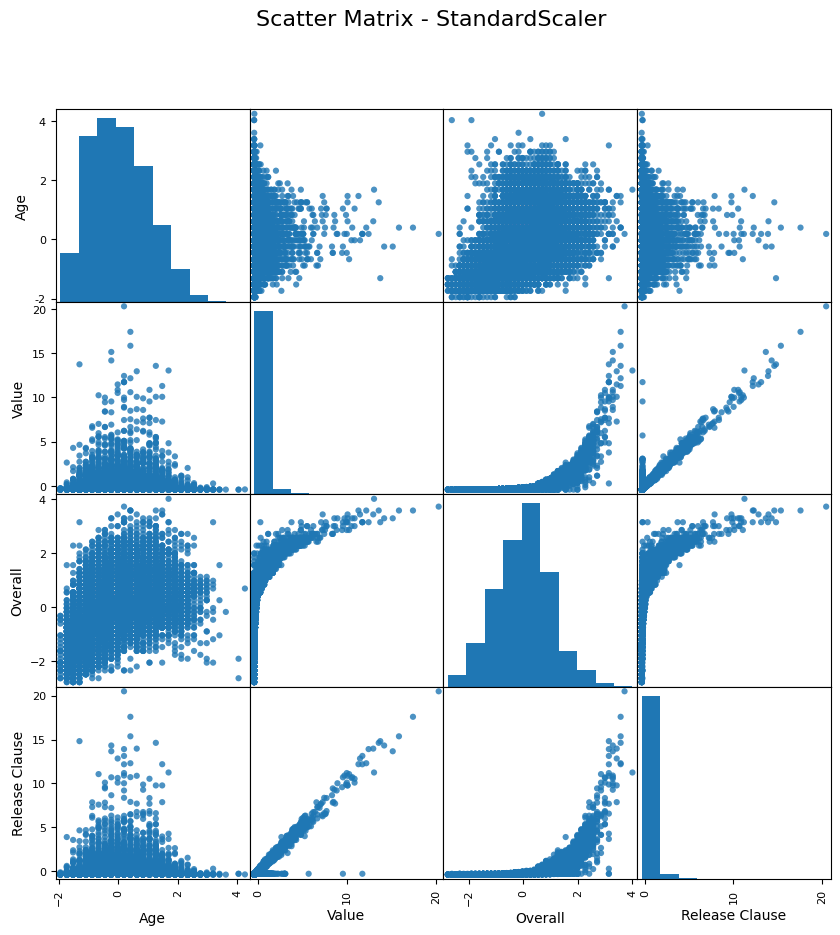

<Figure size 1200x600 with 0 Axes>

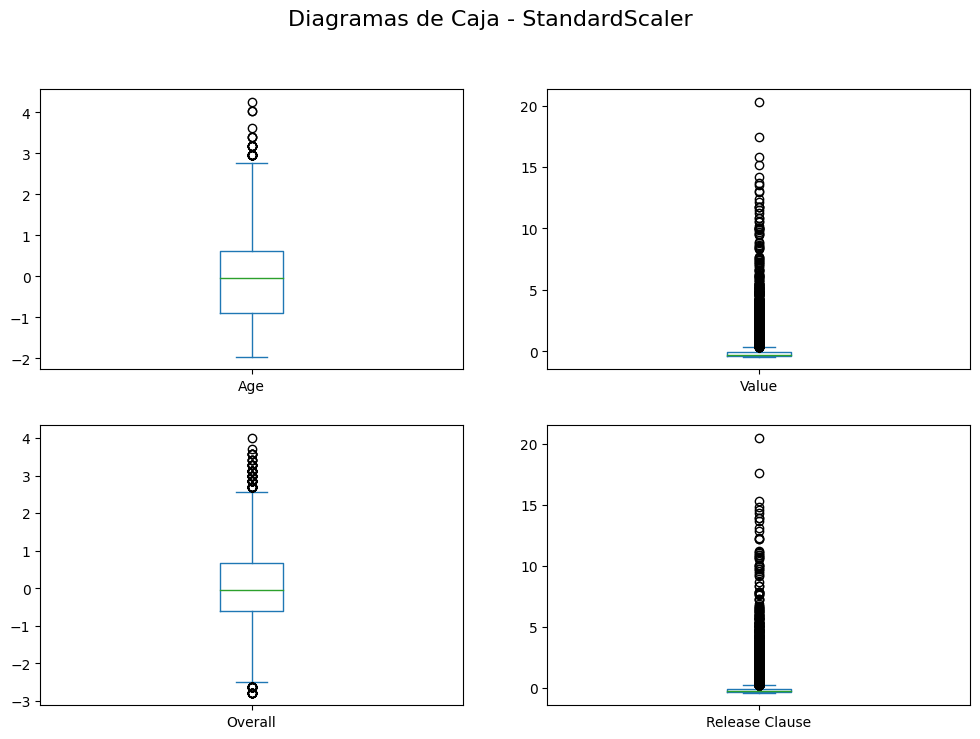

<Figure size 1200x600 with 0 Axes>

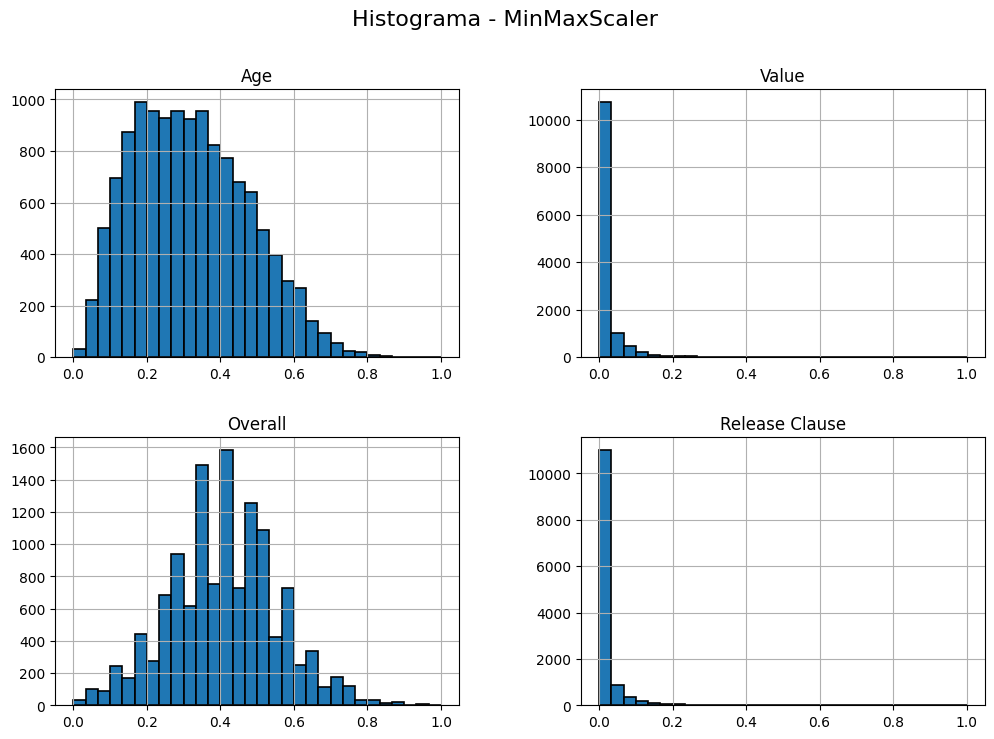

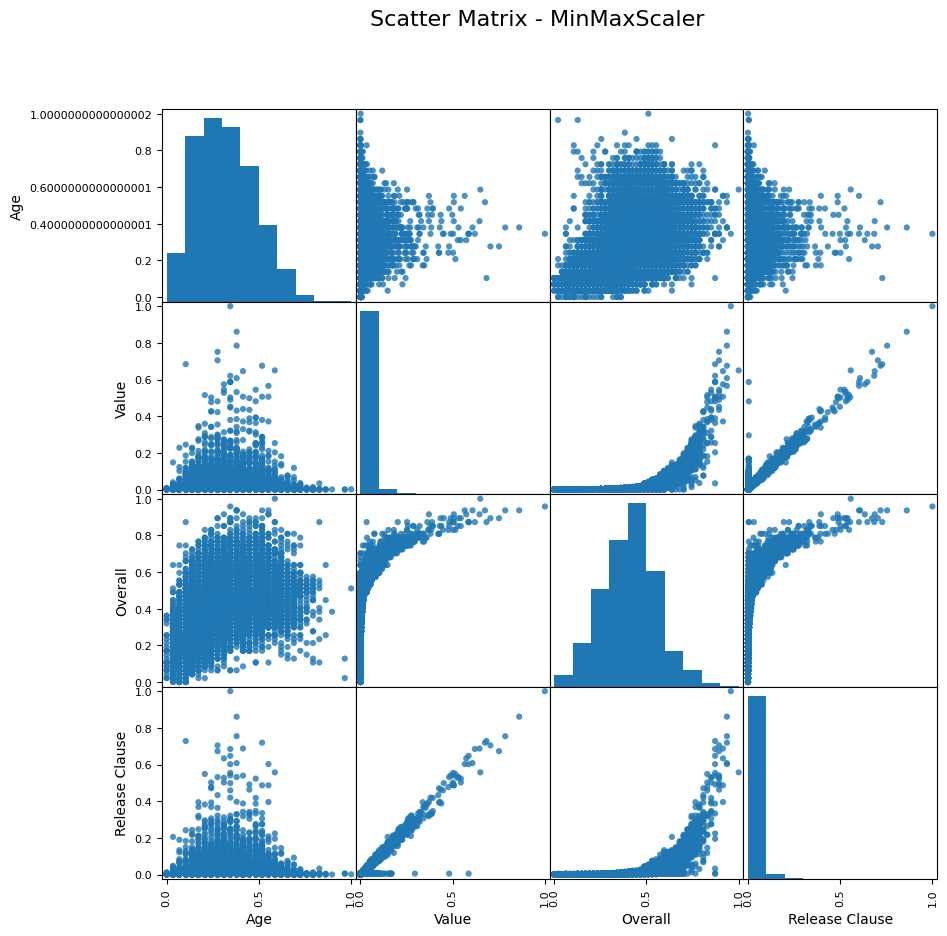

<Figure size 1200x600 with 0 Axes>

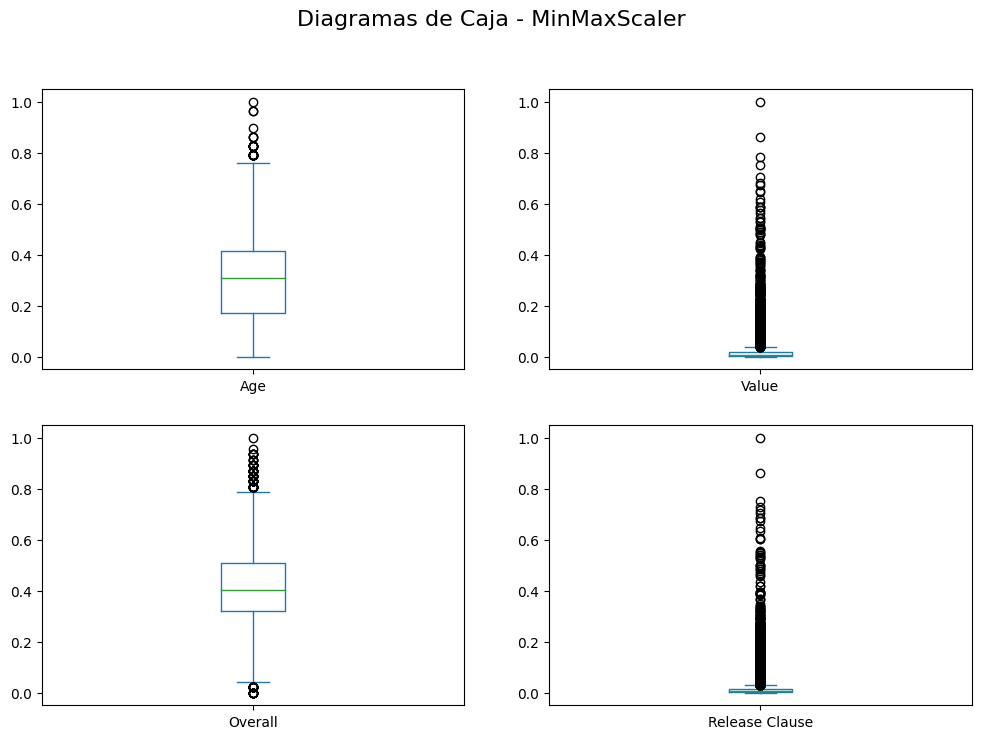

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pandas.plotting import scatter_matrix
import seaborn as sns

# Crear DataFrame de entrenamiento preprocesado que incluya la salida 'Release Clause'
Xtrain_pre['Release Clause'] = ytrain_num

# Seleccionar tres atributos de entrada para la visualización junto con la salida
selected_features = ['Age', 'Value', 'Overall']  # Puedes ajustar estas características según la correlación

# Crear un nuevo DataFrame con las tres características seleccionadas y la variable de salida
df_selected = Xtrain_pre[selected_features + ['Release Clause']]

# 1. Datos Preprocesados (sin escalado)
# Histograma
plt.figure(figsize=(12, 6))
df_selected.hist(bins=30, edgecolor='black', linewidth=1.2, figsize=(12, 8))
plt.suptitle("Histograma - Datos Preprocesados", fontsize=16)
plt.show()

# Scatter Matrix
scatter_matrix(df_selected, alpha=0.8, figsize=(10, 10), diagonal='hist', marker='o', s=20)
plt.suptitle("Scatter Matrix - Datos Preprocesados", fontsize=16)
plt.show()

# Diagramas de Caja
plt.figure(figsize=(12, 6))
df_selected.plot(kind='box', subplots=True, layout=(2, 2), figsize=(12, 8), sharex=False, sharey=False)
plt.suptitle("Diagramas de Caja - Datos Preprocesados", fontsize=16)
plt.show()

# 2. Datos Preprocesados con StandardScaler
scaler_standard = StandardScaler()
df_standard_scaled = pd.DataFrame(scaler_standard.fit_transform(df_selected), columns=df_selected.columns)

# Histograma
plt.figure(figsize=(12, 6))
df_standard_scaled.hist(bins=30, edgecolor='black', linewidth=1.2, figsize=(12, 8))
plt.suptitle("Histograma - StandardScaler", fontsize=16)
plt.show()

# Scatter Matrix
scatter_matrix(df_standard_scaled, alpha=0.8, figsize=(10, 10), diagonal='hist', marker='o', s=20)
plt.suptitle("Scatter Matrix - StandardScaler", fontsize=16)
plt.show()

# Diagramas de Caja
plt.figure(figsize=(12, 6))
df_standard_scaled.plot(kind='box', subplots=True, layout=(2, 2), figsize=(12, 8), sharex=False, sharey=False)
plt.suptitle("Diagramas de Caja - StandardScaler", fontsize=16)
plt.show()

# 3. Datos Preprocesados con MinMaxScaler
scaler_minmax = MinMaxScaler()
df_minmax_scaled = pd.DataFrame(scaler_minmax.fit_transform(df_selected), columns=df_selected.columns)

# Histograma
plt.figure(figsize=(12, 6))
df_minmax_scaled.hist(bins=30, edgecolor='black', linewidth=1.2, figsize=(12, 8))
plt.suptitle("Histograma - MinMaxScaler", fontsize=16)
plt.show()

# Scatter Matrix
scatter_matrix(df_minmax_scaled, alpha=0.8, figsize=(10, 10), diagonal='hist', marker='o', s=20)
plt.suptitle("Scatter Matrix - MinMaxScaler", fontsize=16)
plt.show()

# Diagramas de Caja
plt.figure(figsize=(12, 6))
df_minmax_scaled.plot(kind='box', subplots=True, layout=(2, 2), figsize=(12, 8), sharex=False, sharey=False)
plt.suptitle("Diagramas de Caja - MinMaxScaler", fontsize=16)
plt.show()


In [19]:
Xtrain_pre.columns #atributos disponibles

Index(['Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value', 'Wage',
       'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Contract Valid Until', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
 

In [20]:
Xm =pd.DataFrame(Xtrain_pre[['Age','Overall','Potential']],columns=['Age','Overall','Potential'])#definir pandas con atributos seleccionados
Xm['Output'] = ytrain_num #agregar salida

Xtrain_pre2 = Xtrain_pre.copy()
Xtrain_pre2['output'] = ytrain_num
corr_matrix2 = Xtrain_pre2.corr()#matriz de correlación
corr_matrix2.style.background_gradient(cmap='coolwarm')




In [21]:
abs(corr_matrix2["output"]).sort_values(ascending=False)

output                      1.000000
Value                       0.964206
Wage                        0.809588
International Reputation    0.604959
Overall                     0.587248
                              ...   
GKPositioning               0.033662
Weight                      0.030400
Preferred Foot              0.026350
Nationality                 0.015817
Height                      0.002366
Name: output, Length: 82, dtype: float64

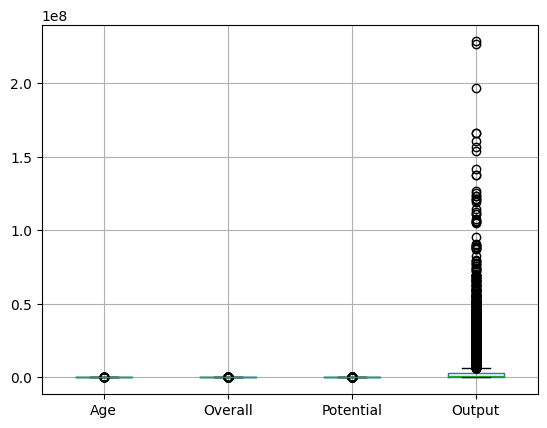

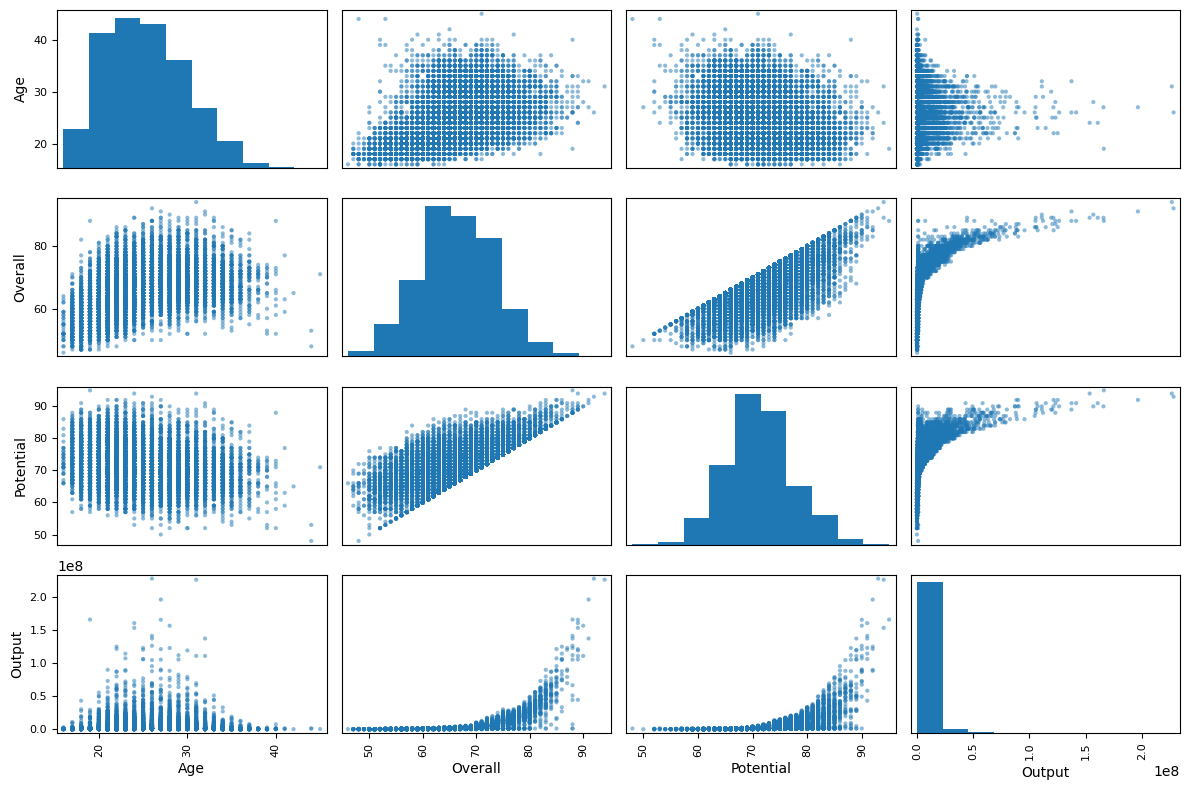

In [22]:
from pandas.plotting import scatter_matrix

Xm.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

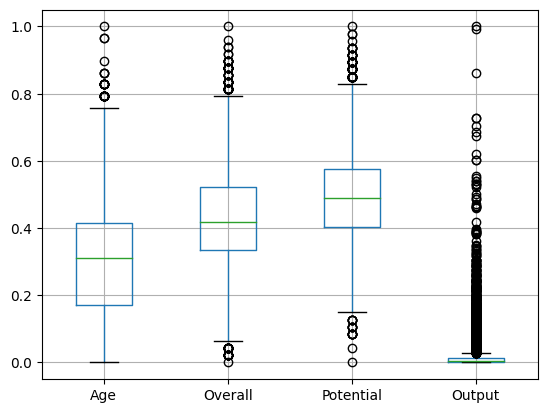

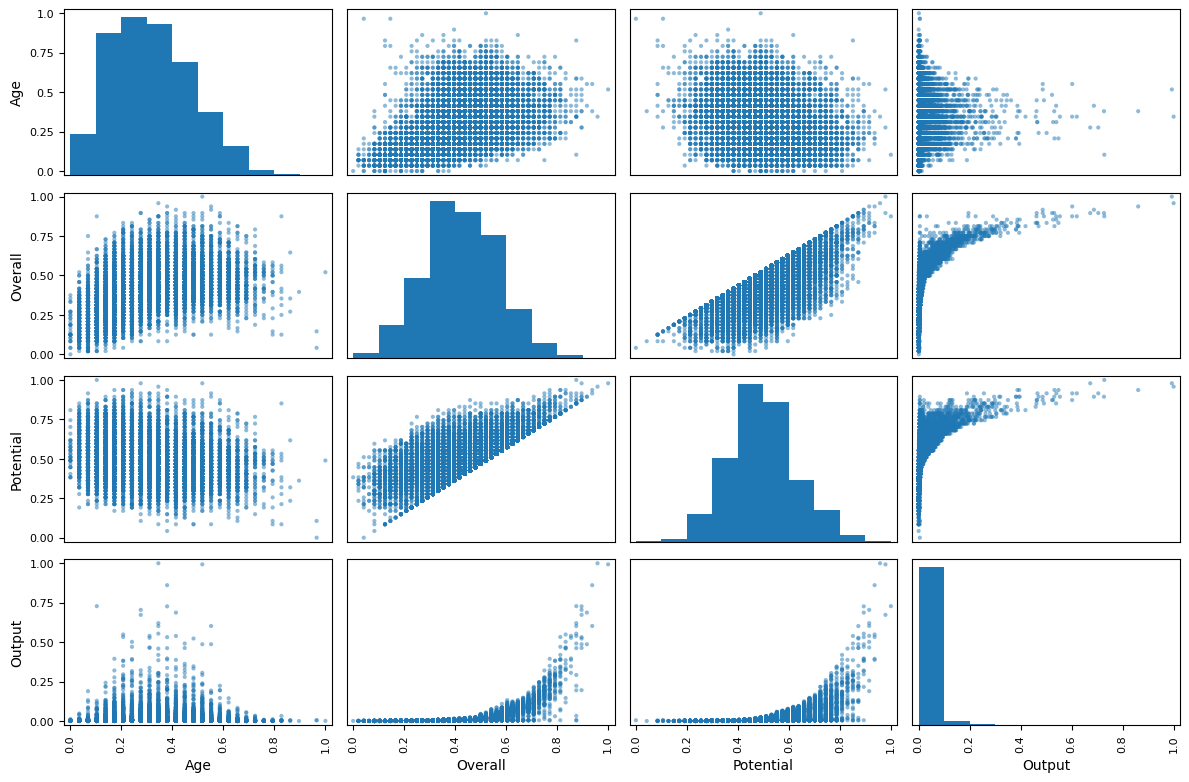

In [23]:
from sklearn.preprocessing import MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

Xm_pre_sca = pd.DataFrame(scaler.fit_transform(Xm),columns=Xm.columns)
Xm_pre_sca.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm_pre_sca, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()


# Se define pipeline para entrenar un modelo de regresión

**Nota:** Se sugiere utilizar un preproceso de normalización tipo StandardScaler o MinMaxScaler para evitar problemas de escala a la hora de identificar los patrones de interés.


A continuación se genera pipeline completo inlcuyendo preproceso custom, standardscaler y modelo de regresión lineal por mínimos cuadrados.

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
steps = [('preproceso',mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)),
         ('scaler', StandardScaler()),
         ('regresion',LinearRegression())
         ]
metodo_full = Pipeline(steps=steps)
metodo_full.fit(Xtrain,ytrain_num) #entrena todos los pasos

Pipeline(steps=[('preproceso',
                 mypre_fifa(cat_usr={'Body Type': ['Normal', 'Lean', 'Stocky',
                                                   'Messi', 'C. Ronaldo',
                                                   'Neymar', 'Courtois',
                                                   'PLAYER_BODY_TYPE_25',
                                                   'Shaqiri', 'Akinfenwa'],
                                     'Club': ['Fortuna Düsseldorf',
                                              'FC Barcelona',
                                              'Newcastle United', 'Frosinone',
                                              'CD Leganés', 'Rayo Vallecano',
                                              'Empoli', 'Cardiff City',
                                              'AS Monaco',
                                              'TSG 1899 Hoffenheim',
                                              'Eintracht Frankfurt',
                                              'Ma...
                                     'Work Rate': ['Medium/ Medium',
                                                   'High/ Medium',
                                                   'Medium/ High', 'High/ High',
                                                   'Medium/ Low', 'High/ Low',
                                                   'Low/ Medium', 'Low/ High',
                                                   'Low/ Low']},
                            col_euro=['Value', 'Wage'],
                            col_stats=['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF',
                                       'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
                                       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
                                       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB',
                                       'RB'])),
                ('scaler', StandardScaler()),
                ('regresion', LinearRegression())])

In [69]:
ytest_e = metodo_full.predict(Xtest) #se evalua el desempeño en el conjunto de test


Se grafican salida original y las predicciones

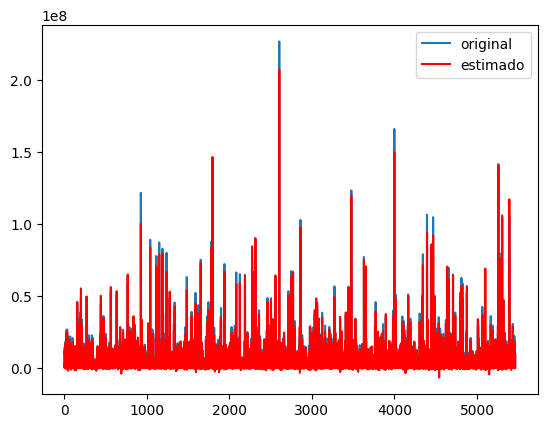

In [70]:
plt.plot(ytest_num,label='original')
plt.plot(ytest_e,'r',label='estimado')

plt.legend()
plt.show()

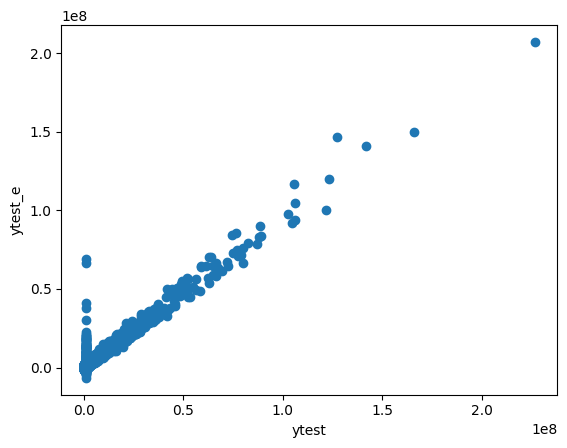

In [71]:
plt.scatter(ytest_num,ytest_e)
plt.xlabel('ytest')
plt.ylabel('ytest_e')
plt.show()

# Ejercicio 3

1. Utilizando el método steps del pipeline, realice una gráfica de las cargas (pesos) del modelo lineal entrenado. Qué puede discutir al respecto?

2. Consulte y presente el modelo y problema de optimización de los siguientes regresores:

 - [LinearRegresor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
 - [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
 - [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
 - [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
 - [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)
 - [BayesianRidge](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression)
 - [Gaussian Process Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)

3. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento preprocesado, compare el rendimiento en el conjunto de test de los regresores del punto 2. fijando el score del [gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) en términos del error absoluto medio y el error cuádratico medio. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 2. Para el caso del kernelRidge y GPR se sugiere trabajar sobre un conjunto de train de 5000 puntos para evitar problemas de memoría en los cálculos de la matriz kernel (presente los resultados para kernel ridge utilizando una función rbf).



In [72]:
metodo_full.steps[2][1].coef_.shape

(81,)

La gráfica muestra la magnitud de los pesos (
𝑤
𝑗
w
j
​
 ) de los diferentes atributos en un modelo de regresión lineal entrenado. A partir de esta visualización, se pueden discutir varios puntos:

Distribución de la importancia de los atributos:

Se observa que la mayoría de los atributos tienen pesos muy cercanos a cero, lo que indica que su influencia en el modelo es mínima o nula.
Hay algunos atributos, en particular alrededor de los índices 30 a 40, que tienen valores significativamente más grandes. Esto sugiere que estos atributos son los que tienen una mayor importancia o relación con la variable objetivo.
Interpretación de los picos:

El pico más alto indica un atributo que tiene una contribución extremadamente grande en comparación con el resto. Es importante analizar este atributo con mayor detalle para entender por qué está tan destacado y si tiene sentido desde el punto de vista del dominio del problema.
En la práctica, una diferencia tan marcada en las magnitudes de los pesos podría sugerir problemas con los datos, como multicolinealidad o mala normalización.
Posibles problemas:

Los valores excesivamente altos (en el orden de
1
0
18
10
18
 ) podrían indicar un problema de escalado de los datos. Es posible que algunos atributos no estén adecuadamente normalizados o estandarizados, lo que podría estar afectando los coeficientes del modelo.
Podría ser útil realizar un preprocesamiento adicional, como estandarización o normalización, para evitar que algunos atributos dominen el modelo debido a su escala.

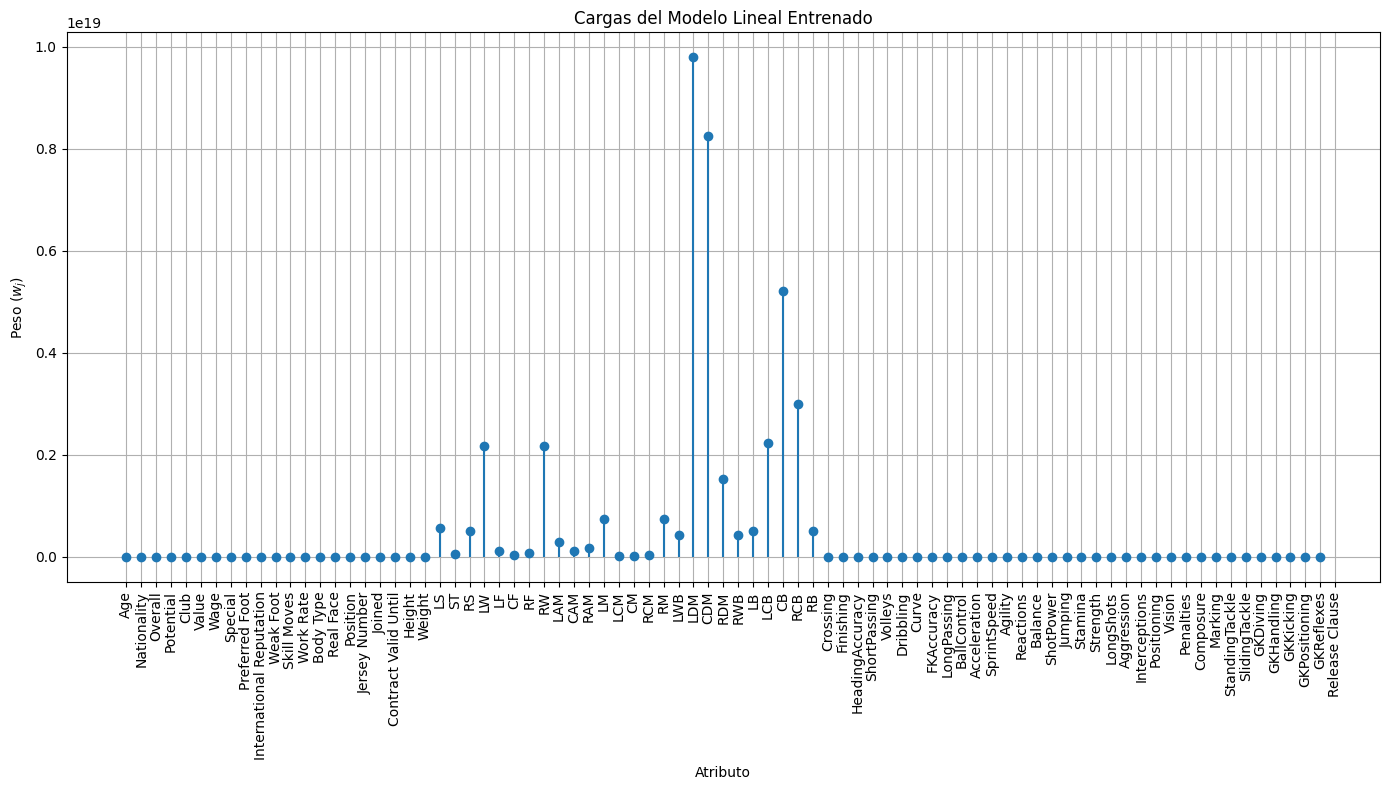

In [75]:
import matplotlib.pyplot as plt

# Extraer el modelo lineal del pipeline
linear_model = metodo_full.steps[2][1]

# Obtener los coeficientes (cargas/pesos) del modelo
coefs = linear_model.coef_

# Crear etiquetas para cada atributo a partir del DataFrame preprocesado
atributos = Xtrain_pre.columns

# Crear una gráfica de los valores absolutos de los coeficientes para resaltar la importancia de cada característica
plt.figure(figsize=(14, 8))
plt.stem(abs(coefs), basefmt=" ", use_line_collection=True)
plt.xticks(ticks=np.arange(len(atributos)), labels=atributos, rotation=90)  # Etiquetar con los nombres de los atributos
plt.xlabel('Atributo')
plt.ylabel('Peso ($w_j$)')
plt.title('Cargas del Modelo Lineal Entrenado')
plt.grid()
plt.tight_layout()
plt.show()


In [30]:
#Ayuda punto 2 y 3
#Dado que el preproceso no cambia, se sugiera generar el pipeline sin mypre_fifa para ahorrar tiempo
steps = [('scaler', StandardScaler()), #ajustar según ejercicio
         ('regresion',LinearRegression()) #ajustar según ejercicio
         ]
metodo_gs = Pipeline(steps=steps) #pipeline a utilizar en el gridsearch
#Recuerde realizar el fit del gridsearch sobre las matrices de entrada y vector de salida preprocesados
#Xtrain_pre ytrain_num


**1. Linear Regressor (Regresión Lineal)** \\
El modelo de regresión lineal busca encontrar una relación lineal entre las variables predictoras ($X$) y la variable objetivo ($y$). El modelo está definido como:

$$
y = X \beta + \epsilon
$$

Donde:
- $X$ son las variables predictoras.
- $\beta$ es el vector de coeficientes a estimar.
- $\epsilon$ es el error o residuo.

El problema de optimización se basa en minimizar el error cuadrático medio (MSE), lo que se formaliza como:

$$
\min_{\beta} \sum_{i=1}^n (y_i - X_i \beta)^2
$$

Este es un problema de mínimos cuadrados ordinarios (OLS).

**2. Lasso (Least Absolute Shrinkage and Selection Operator)** \\
El modelo Lasso es una regresión lineal con regularización $L_1$. El objetivo es minimizar la suma de los errores cuadráticos junto con la penalización $L_1$, lo que induce sparsity (muchos coeficientes se vuelven cero):

$$
\min_{\beta} \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda \sum_{j=1}^p |\beta_j|
$$

Donde:
- $\lambda$ es el parámetro de regularización que controla la magnitud de la penalización.

**3. ElasticNet** \\
El modelo ElasticNet combina las penalizaciones de $L_1$ (Lasso) y $L_2$ (Ridge) en un solo problema de optimización. Se utiliza cuando se espera que algunas características sean correlacionadas.

El problema de optimización es:

$$
\min_{\beta} \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda_1 \sum_{j=1}^p |\beta_j| + \lambda_2 \sum_{j=1}^p \beta_j^2
$$

Donde:
- $\lambda_1$ controla la penalización $L_1$ (sparsity).
- $\lambda_2$ controla la penalización $L_2$ (regularización).

**4. Kernel Ridge** \\
El modelo Kernel Ridge combina la regresión Ridge con la idea de transformar los datos a un espacio de características de mayor dimensión utilizando un kernel (función de similitud).

El problema de optimización se plantea como:

$$
\min_{\beta} \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda \| \beta \|^2
$$

Sin embargo, se realiza en un espacio transformado por un kernel $K(X, X')$, lo que permite modelar relaciones no lineales.

**5. SGDRegressor (Stochastic Gradient Descent Regressor)**\\
El modelo SGDRegressor minimiza el error cuadrático medio, pero en lugar de usar un enfoque analítico, utiliza descenso de gradiente estocástico para encontrar los coeficientes $\beta$.

El problema de optimización es similar al de la regresión lineal, pero con un enfoque iterativo:

$$
\min_{\beta} \frac{1}{n} \sum_{i=1}^n (y_i - X_i \beta)^2
$$

El modelo ajusta los coeficientes $\beta$ mediante actualizaciones iterativas basadas en gradientes calculados sobre mini-lotes o ejemplos individuales.

**6. Bayesian Ridge** \\
El \textit{modelo Bayesian Ridge} es una extensión de la regresión Ridge donde los coeficientes $\beta$ son tratados como variables aleatorias con una distribución a priori.

El problema de optimización es probabilístico:

$$
p(\beta | X, y) \propto p(y | X, \beta) p(\beta)
$$

Donde:
- $p(\beta)$ es la distribución a priori sobre los coeficientes $\beta$.
- $p(y | X, \beta)$ es la verosimilitud condicional de los datos dados los coeficientes.

El objetivo es encontrar la distribución a posteriori de los coeficientes $\beta$.

**7. Gaussian Process Regressor** \\
El \textit{modelo Gaussian Process Regressor} (GPR) asume que los datos provienen de un proceso gaussiano. A diferencia de los modelos lineales, GPR modela la distribución de probabilidad sobre las funciones y no directamente sobre los coeficientes.

El problema de optimización implica maximizar la probabilidad marginal (o el logaritmo de esta) para los parámetros del kernel:

$$
\log p(y | X) = -\frac{1}{2} y^T K^{-1} y - \frac{1}{2} \log |K| - \frac{n}{2} \log 2\pi
$$

Donde:
- $K$ es la matriz de covarianza (definida por un kernel) que describe las relaciones entre los puntos de datos.
- $y$ es el vector de observaciones.



In [31]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

# Definir el pipeline completo con preprocesamiento
steps = [('preproceso', mypre_fifa(col_euro=col_euro, col_stats=col_stats, cat_usr=cat_usr)),
         ('scaler', StandardScaler())]

# Preprocesar las matrices de entrada
metodo_preprocess = Pipeline(steps=steps)
X_train_pre = metodo_preprocess.fit_transform(Xtrain)
X_test_pre = metodo_preprocess.transform(Xtest)
y_train_num = ytrain_num  # La variable de salida ya está definida

# Funciones de evaluación (scoring)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Hiperparámetros para cada regresor
param_grid = {
    'LinearRegression': {
        'regresion': [LinearRegression()]
    },
    'Lasso': {
        'regresion': [Lasso()],
        'regresion__alpha': [0.01, 0.1, 1, 10]
    },
    'ElasticNet': {
        'regresion': [ElasticNet()],
        'regresion__alpha': [0.01, 0.1, 1, 10],
        'regresion__l1_ratio': [0.2, 0.5, 0.8]
    },
    'SGDRegressor': {
        'regresion': [SGDRegressor(max_iter=1000)],
        'regresion__alpha': [0.001, 0.01, 0.1, 1],
        'regresion__penalty': ['l2', 'l1', 'elasticnet']
    },
    'BayesianRidge': {
        'regresion': [BayesianRidge()]
    },
    'KernelRidge': {
        'regresion': [KernelRidge(kernel='rbf')],
        'regresion__alpha': [0.1, 1, 10],
        'regresion__gamma': [0.01, 0.1, 1]
    },
    'GaussianProcessRegressor': {
        'regresion': [GaussianProcessRegressor(kernel=RBF())],
        'regresion__alpha': [1e-10, 1e-5, 1e-2]
    }
}

# Crear el pipeline base
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('regresion', LinearRegression())])

# Seleccionar un subconjunto de 5000 puntos para Kernel Ridge y GPR
X_train_sub, _, y_train_sub, _ = train_test_split(X_train_pre, y_train_num, train_size=5000, random_state=42)

# Función para ajustar y evaluar cada modelo
def fit_and_evaluate(regressor_name, X, y):
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid[regressor_name],
                        cv=5, scoring={'MAE': mae_scorer, 'MSE': mse_scorer}, refit='MAE')

    grid.fit(X, y)
    print(f"Resultados para {regressor_name}:")
    print(f"Mejor MAE: {abs(grid.best_score_)}")
    print(f"Mejores hiperparámetros: {grid.best_params_}")
    return grid

# Evaluar todos los modelos excepto KernelRidge y GPR
model_names = ['LinearRegression', 'Lasso', 'ElasticNet', 'SGDRegressor', 'BayesianRidge']
for model_name in model_names:
    fit_and_evaluate(model_name, X_train_pre, y_train_num)

# Evaluar KernelRidge y GPR con 5000 puntos
fit_and_evaluate('KernelRidge', X_train_sub, y_train_sub)
fit_and_evaluate('GaussianProcessRegressor', X_train_sub, y_train_sub)


Resultados para LinearRegression:
Mejor MAE: 966068.1133999558
Mejores hiperparámetros: {'regresion': LinearRegression()}
Resultados para Lasso:
Mejor MAE: 948546.6463488514
Mejores hiperparámetros: {'regresion': Lasso(), 'regresion__alpha': 10}
Resultados para ElasticNet:
Mejor MAE: 910005.5711961963
Mejores hiperparámetros: {'regresion': ElasticNet(), 'regresion__alpha': 0.1, 'regresion__l1_ratio': 0.8}
Resultados para SGDRegressor:
Mejor MAE: 947024.1675084617
Mejores hiperparámetros: {'regresion': SGDRegressor(), 'regresion__alpha': 0.001, 'regresion__penalty': 'l2'}
Resultados para BayesianRidge:
Mejor MAE: 947274.0432541178
Mejores hiperparámetros: {'regresion': BayesianRidge()}
Resultados para KernelRidge:
Mejor MAE: 1073748.9955740676
Mejores hiperparámetros: {'regresion': KernelRidge(kernel='rbf'), 'regresion__alpha': 0.1, 'regresion__gamma': 0.01}
Resultados para GaussianProcessRegressor:
Mejor MAE: 1275704.8178775061
Mejores hiperparámetros: {'regresion': GaussianProcessRegr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regresion', LinearRegression())]),
             param_grid={'regresion': [GaussianProcessRegressor(kernel=RBF(length_scale=1))],
                         'regresion__alpha': [1e-10, 1e-05, 0.01]},
             refit='MAE',
             scoring={'MAE': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, greater_is_better=False, response_method='predict')})